In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
import multiprocessing as mp
import itertools as it
import numpy as np

codeLocation = os.path.join(os.getcwd(), "..", "src")
sys.path.append(codeLocation)

import tsp_sim_randomTowns as twn
import tsp_procu as tsp
import mse_messaging as mse


print("Ok!")

Ok!


In [13]:
##
n = 12
towns = twn.generateTowns(n=n)
xs = [t[1][0] for t in towns]
ys = [t[1][1] for t in towns]
distmat = tsp.xyDistMatrix(xs, ys)

print("Ok!")

Ok!


Progress: 19958000/Unknown
Ok! Time taken: 57.41 sec.
Shortest route: (5, 3, 11, 6, 8, 10, 4, 7, 1, 2, 9)
Shortest distance: 6.78089446837579


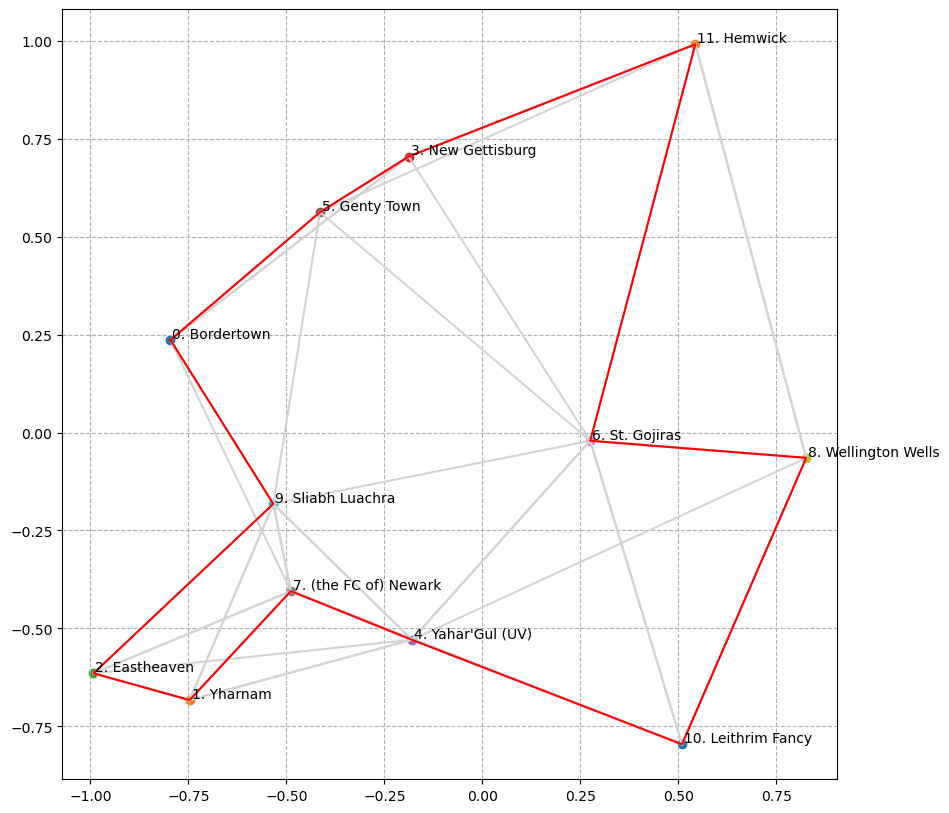

In [16]:
## ##
'''
routesWithDists = [(route, routeLength(distmat)(route)) for route in list(routes) \
                   if route[0]<route[-1]]

# route = sorted(routesWithDists, key=lambda x: x[1])[0]
routesWithDists = sorted(routesWithDists, key=lambda x: x[1])
'''

## ##
routes = it.permutations(range(1, n))

distanceMin = np.finfo(np.float32).max
routeMin = None
counter = 0

timeStart = time.time()
running = True
while running:
    try:
        route = next(routes)
        if route[0] < route[-1]:
            distance = tsp.xyCountRoute(distmat)(route)

            if distance < distanceMin:
                distanceMin = distance
                routeMin = route

            counter += 1
            if counter % 500 == 0:
                print("Progress: {}/Unknown".format(counter), end="\r")
        
    except Exception as e:
        print(e)
        running = False
        
timeTaken = time.time() - timeStart
print("Ok! Time taken: {} sec.".format("%.2f"%timeTaken))

print("Shortest route: {}".format(routeMin))
print("Shortest distance: {}".format(distanceMin))

travel = [towns[i] for i in (0,)+routeMin+(0,)]
twn.plotTowns(towns, shortestRoute=travel)

HST: Combinations count: 19958400. For 8 workers
HST: Queues created
HST: Workers started
HST: Ignition...
Starting cycle...
HST: No work to do. Stopping everything...
HST: No work to do. Stopping everything...
HST: No work to do. Stopping everything...
HST: No work to do. Stopping everything...
HST: No work to do. Stopping everything...
HST: No work to do. Stopping everything...
HST: No work to do. Stopping everything...
HST: No work to do. Stopping everything...
WRK_05: Worker 05 got a got a poison message and stops
WRK_03: Worker 03 got a got a poison message and stops
WRK_04: Worker 04 got a got a poison message and stops
WRK_07: Worker 07 got a got a poison message and stops
WRK_08: Worker 08 got a got a poison message and stops
WRK_02: Worker 02 got a got a poison message and stops
WRK_06: Worker 06 got a got a poison message and stops
HST: All processes stopped: True
Shortest route: (5, 3, 11, 6, 8, 10, 7, 4, 2, 1, 9)
Shortest distance: 6.78089446837579
Ok! Time taken: 1849.41 s

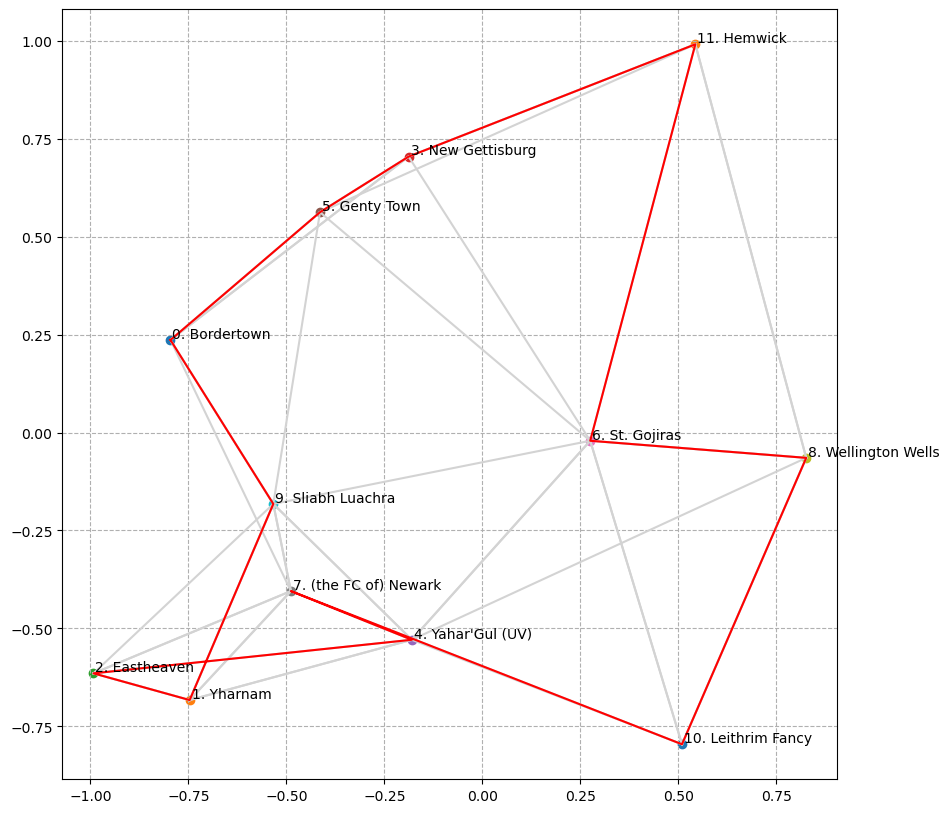

In [15]:
def tspWorkerFn(queIn, queOut, distanceMatrix, workerId):
    running = True
    while running:
        msg = queIn.get()
        
        ## ##
        if isinstance(msg, mse.PoisonMessage):
            running = False
            queOut.put(mse.PoisonMessage(actorId=workerId))
            
        elif isinstance(msg, mse.DataMessage):
            route = msg.data
            distance = tsp.xyCountRoute(distanceMatrix)(route)
            queOut.put(mse.DataMessage(data=(route, distance), actorId=workerId))
            
        else:
            queOut.put(mse.InfoMessage(text="Worker {} got a message of unknown purpose".format(workerId),
                                       actorId=workerId))
            
    ## ##
    queOut.put(mse.InfoMessage(text="Worker {} got a got a poison message and stops".format(workerId),
                               actorId=workerId))
    
    ## ##
    return()


## ##
##
numWorkers = 8

## ##
numCombinations = np.prod(range(1,n)) // 2
numWorkers = min(numWorkers, numCombinations)
print("HST: Combinations count: {}. For {} workers".format(numCombinations, numWorkers))

queIn = mp.Queue()
queOut = mp.Queue()
print("HST: Queues created")

procs = [mp.Process(target=tspWorkerFn, kwargs={"queIn":queOut, "queOut":queIn,
                                                "distanceMatrix":distmat, "workerId":"%02i"%i}) \
         for i in range(1, numWorkers+1)]

for p in procs:
    p.start()
print("HST: Workers started")

## ##
routes = it.permutations(range(1, n))

distanceMin = np.finfo(np.float32).max
routeMin = None
counter = 0

## Ignition
print("HST: Ignition...")
for _ in range(numWorkers):
    queOut.put(mse.DataMessage(data=next(routes)))
    
workersInOperation = numWorkers

## ##
print("Starting cycle...")
timeStart = time.time()
running = True
while running:
    msg = queIn.get()
    
    ##
    if isinstance(msg, mse.PoisonMessage):
        workersInOperation -= 1
        if workersInOperation < 1:
            running = False
        
    elif isinstance(msg, mse.DataMessage):
        route, distance = msg.data
        
        try:
            search = True
            while search:
                route = next(routes)
                if route[0] < route[-1]:
                    search = False
                    
            queOut.put(mse.DataMessage(data=route))
            
        except Exception as e:
            if isinstance(e, StopIteration):
                for _ in range(numWorkers):
                    queOut.put(mse.PoisonMessage())
                print("HST: No work to do. Stopping everything...")
            else:
                for _ in range(numWorkers*2):
                    queOut.put(mse.PoisonMessage())
                print("HST: Something went wrong. {}. Trying to stop everything...".format(e))
        
        if distance < distanceMin:
            distanceMin = distance
            routeMin = route
        
        counter += 1
        print("HST: Progress {}/{}      ".format(counter, numCombinations), end="\r")
        
    elif isinstance(msg, mse.InfoMessage):
        print("WRK_{}: {}".format(msg.actorId, msg.text))
        
## ##
for p in procs:
    p.join()
    
queIn.close()
queOut.close()

print("HST: All processes stopped: {}".format(all([not p.is_alive() for p in procs]))) 

##
print("Shortest route: {}".format(routeMin))
print("Shortest distance: {}".format(distanceMin))

timeTaken = time.time() - timeStart
print("Ok! Time taken: {} sec.".format("%.2f"%timeTaken))

travel = [towns[i] for i in (0,)+routeMin+(0,)]
twn.plotTowns(towns, shortestRoute=travel)

In [ ]:
## Emergency stop

for _ in range(numWorkers*2):
    queOut.put(mse.PoisonMessage())
    
try:
    queIn.close()
    queOut.close()
except Exception as e:
    pass
    
for p in procs:
    p.join()
    
for p in procs:
    print(p.is_alive())